In [ ]:
!pip install pymorphy2
!pip install natasha

In [ ]:
!pip install pandas --upgrade

In [ ]:
import json

from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pymorphy2
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
DATA_PATH = 'data/'
SEED = 349

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=ef597ad14ad2cb86ef66f04c440ef2a648cc2561a2c07b19d587b63b19514f65
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
data = {"username":"iuriierilov","key":"66fee5d328052d1dd8446849ea0ab6e9"}
with open('kaggle.json', 'w') as f:
    json.dump(data, f)

In [ ]:
 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c regulations-outcome
!mkdir data
!unzip regulations-outcome.zip -d data
!rm regulations-outcome.zip
!rm kaggle.json

In [ ]:
data = pd.read_csv('data/regulations.csv')
train_answers = pd.read_csv(DATA_PATH+ 'train_answer.csv')
test_answers_id = list(pd.read_csv(DATA_PATH+'sample_submission.csv')['id'])
assert(set(train_answers['id']) & set(test_answers_id) == set([]))

In [ ]:
train_data = (data[data['id'].isin(list(train_answers.id))]).copy()
train_data['passed'] = pd.Series(list(train_answers.passed), index=train_data.index)
test_data = (data[data['id'].isin(test_answers_id)]).copy()
assert(test_data.shape[0] + train_data.shape[0] == data.shape[0])

In [ ]:
train_data.index = np.arange(0, len(train_data))
test_data.index = np.arange(0, len(test_data))

In [ ]:
text_cols = ['act_title',
            'problem_addressed',
            'act_objectives',
            'persons_affected_by_act',
            'relations_regulated_by_act',
            'act_significance']
        
for col in text_cols:
    print(col)
    print('isna')
    print(test_data[col].isna().sum())
    lens = list(len(i) for i in test_data[col] if i is not np.nan)
    print(len(lens))
    lens = np.array(lens)
    print(lens.mean())
    print(lens.max())
    print(lens.min())
    words = list(len(i.split()) for i in test_data[col] if i is not np.nan)
    words = np.array(words)
    print(words.mean())
    print(words.max())
    print(words.min())

## Тематическое моделирование

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import razdel
from string import punctuation

ru_stopwords = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def preproc(sentence):
  tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence))) if _.text.lower() not in ['№', '«', 'г', '»']]

  final_sentence = []
  for token in tokens:
    token = morph.parse(token)[0].normal_form
    if token not in punctuation and token not in ru_stopwords:
      final_sentence.append(token)
  return final_sentence

In [ ]:
%time train_data['act_title'] = train_data['act_title'].apply(preproc)

CPU times: user 14min, sys: 2.1 s, total: 14min 2s
Wall time: 14min 3s


In [ ]:
train_data[['act_title', 'passed']].head()

,act_title,passed
0,"[утверждение, тариф, услуга, транспортировка, ...",0
1,"[внесение, изменение, отдельный, законодательн...",0
2,"[утверждение, положение, уведомление, лицо, вк...",0
3,"[внесение, изменение, положение, министерство,...",1
5,"[внесение, изменение, федеральный, целевой, пр...",0


In [ ]:
# Compute bigrams.
from gensim.models import Phrases
from gensim.models import CoherenceModel

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(train_data['act_title'], min_count=20)
for idx in range(len(train_data['act_title'])):
    for token in bigram[train_data['act_title'][idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            train_data['act_title'][idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(train_data['act_title'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [ ]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in train_data['act_title'].values]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5536
Number of documents: 81006


## Подбор модели

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
# Can take a long time to run.

# Set training parameters.
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=train_data['act_title'], start=2, limit=10, step=1)

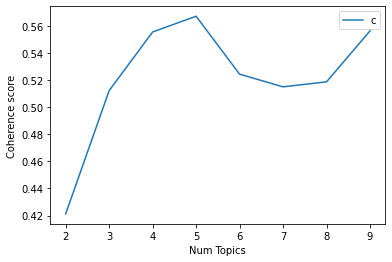

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4212
Num Topics = 3  has Coherence Value of 0.5124
Num Topics = 4  has Coherence Value of 0.5558
Num Topics = 5  has Coherence Value of 0.5674
Num Topics = 6  has Coherence Value of 0.5245
Num Topics = 7  has Coherence Value of 0.5152
Num Topics = 8  has Coherence Value of 0.5189
Num Topics = 9  has Coherence Value of 0.5566


## Итоговая модель

In [ ]:
# Set training parameters.
chunksize = 2000
passes = 20
iterations = 400
num_topics = 5
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
lda_model.print_topics()

[(0,
  '0.066*"федерация" + 0.058*"изменение" + 0.057*"внесение" + 0.041*"правительство" + 0.031*"постановление" + 0.029*"постановление_правительство" + 0.017*"акт" + 0.015*"приказ" + 0.015*"признание" + 0.014*"россия"'),
 (1,
  '0.047*"федерация" + 0.034*"государственный" + 0.031*"федеральный" + 0.027*"приказ" + 0.027*"министерство" + 0.023*"изменение" + 0.023*"внесение" + 0.016*"утверждение" + 0.014*"порядок" + 0.014*"служба"'),
 (2,
  '0.052*"образование" + 0.051*"утверждение" + 0.039*"стандарт" + 0.038*"образовательный" + 0.034*"государственный" + 0.031*"профессиональный" + 0.030*"высокий" + 0.029*"федеральный" + 0.026*"высокий_образование" + 0.021*"подготовка"'),
 (3,
  '0.044*"федеральный" + 0.019*"государственный" + 0.019*"закон" + 0.019*"федерация" + 0.016*"внесение" + 0.016*"изменение" + 0.015*"статья" + 0.014*"гражданский" + 0.013*"служба" + 0.011*"сведение"'),
 (4,
  '0.025*"утверждение" + 0.016*"федеральный" + 0.015*"предоставление" + 0.015*"организация" + 0.015*"бюджет" + 

In [ ]:
lda_model.get_document_topics(dictionary.doc2bow(train_data['act_title'][0]), minimum_probability=0.0)

[(0, 0.9068229),
 (1, 0.035213657),
 (2, 0.009532231),
 (3, 0.013040304),
 (4, 0.035390865)]

## Формирование фичей

In [ ]:
%time test_data['act_title'] = test_data['act_title'].apply(preproc)

In [ ]:
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(test_data['act_title'], min_count=20)
for idx in range(len(test_data['act_title'])):
    for token in bigram[test_data['act_title'][idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            test_data['act_title'][idx].append(token)

In [ ]:
test_data['act_title'].head()

0    [внесение, изменение, правило, подготовка, при...
1    [внесение, изменение, правило, поставка, газ, ...
2    [внесение, изменение, приказ, министерство, зд...
3    [внесение, изменение, отдельный, законодательн...
4    [утверждение, федеральный, норма, правило, обл...
Name: act_title, dtype: object

In [ ]:
test_theme_features = []
for idx in range(len(test_data['act_title'])):
    theme_distribution = lda_model.get_document_topics(dictionary.doc2bow(test_data['act_title'][idx]), minimum_probability=0.0)
    test_theme_features.append([theme_distribution[0][1], theme_distribution[1][1], theme_distribution[2][1], theme_distribution[3][1], theme_distribution[4][1]])

In [ ]:
train_theme_features = []
for idx in range(len(train_data['act_title'])):
    theme_distribution = lda_model.get_document_topics(dictionary.doc2bow(train_data['act_title'][idx]), minimum_probability=0.0)
    train_theme_features.append([theme_distribution[0][1], theme_distribution[1][1], theme_distribution[2][1], theme_distribution[3][1], theme_distribution[4][1]])

In [ ]:
test_theme_features = pd.DataFrame(test_theme_features, columns=['theme_1', 'theme_2', 'theme_3', 'theme_4', 'theme_5'])

pd.set_option('display.max_rows', None)
with open('test_theme_features.csv', 'w') as file:
  file.write(str(test_theme_features))

In [ ]:
train_theme_features = pd.DataFrame(train_theme_features, columns=['theme_1', 'theme_2', 'theme_3', 'theme_4', 'theme_5'])

with open('train_theme_features.csv', 'w') as file:
  file.write(str(train_theme_features))